Tanner, Noah\
HW 0x03 Systems Modeling\
ME 405 - Professor Refvem\
Fall 2023

HW 0x03 Systems Modeling
ME 405 - Professor Refvem
Fall 2023

In [73]:
from numpy import array, arange, zeros, transpose
from matplotlib import pyplot, rc
from math import pi, cos, sin

Systems Model:\
\
In order to model the Romi robot system as a differential drive robot, and not a "unicycle" model, the independent characteristics of each wheel must be considered. In the image below, there is an independent velocity vector for the left and right wheels, as well as a combined velocity vector that makes up the velocity at a central point, inbetween the two wheels. The two coordinate systems, X,Y (Global), and X_R, Y_R (Local to the robot) are also pictured.
\
<img src="./Model_Pic.png" alt="Diagram of Romi Model" style="height:300px;" />
\
Some variables have been defined as well in order to understand the equations.
\
\
𝜔_r = Angular velocity of right wheel (rad/s)\
𝜔_l = Angular velocity of left wheel (rad/s)\
R       = Radius (R_r = R-l = R, unless otherwise noted)\
L       = Distance between the two wheels (Radius of rotation)

The following differential equations reflect the dynamics associated with a two wheel, differential drive robot. 

$$
\begin{array}{rl}
\frac{d}{dt}X           &= \left( \frac{R}{2} \left( \omega_r + \omega_l \right) 
\cos\theta \right)\\
\frac{d}{dt}Y           &= \left( \frac{R}{2} \left( \omega_r + \omega_l \right) 
\sin\theta \right)\\
\frac{d}{dt}\theta      &= \left( \frac{R}{L} \left( \omega_r + \omega_l \right) 
\right)
\end{array}
$$

Combining the preceding equations, a single vector equation can be obtained that can be solved using vector based ODE solution techniques.

$$
\begin{array}{rl}
\frac{d}{dt}
    \begin{bmatrix}
        X \\
        Y \\
        \theta
    \end{bmatrix}
&=
\begin{bmatrix}
    \frac{R}{2} \left( \omega_r - \omega_l \right)cos \theta \\
    \frac{R}{2} \left( \omega_r - \omega_l \right)sin \theta \\
    \frac{R}{L} \left( \omega_r - \omega_l \right)
\end{bmatrix} \\

\end{array}
$$



In [74]:
# mechanical properties
R       = 2.83 / 2          # radius of wheel [ in ]
L       = 4.92 / 2          # distance between the two wheels [ in ]

# input radius and desired tangential speed of robot
rad     = 4                 # [ in ]
vel     = 2                 # [ rad/s ]

In [75]:
def system_eqn_ol(t, x):
    '''!@brief      Implements both state equations and output equations for the open loop system
        @param t    The value of time for a given simulation step
        @param x    The value of the state vector for a given simulation step
        @return     A tuple containing both the derivative of the state vector and the output
                    vector for a given simulation step
    '''
    
    # take input velocity and circle radius and back solve for angular velocity of romi
    omg_romi = vel / rad
    
    # set theta equal to the final value in the output array for each solved iteration [ rad ]
    theta = x[2]
    
    # calculate anuglar velocities of left and right wheel based off of romi angular velocity
    omg_r = (vel + (omg_romi*L)) / rad
    omg_l  = (vel - (omg_romi*L)) / rad
    
    xd = array([    [ (R/2) * cos(theta) * (omg_r + omg_l) ],
                    [ (R/2) * sin(theta) * (omg_r + omg_l) ],
                    [ omg_romi ] ])

    # y = [ x, y, theta ]
    y     = array([ [x[0]],
                    [x[1]],
                    [x[2]] ])

    return xd, y

## Runge-Kutta Method (4th order)
The Runge-Kutta Method is the method of solving used in this homework as the integration technqiue is fourth order, allowing for a smaller truncation error for a given step size. This allows for a more reasonable step size while maintaining the reasonable accuracy of the solution. The algoritihm is similar to Euler's method, however it splits the window of time, $\Delta t$ in half, and computes the derivative several times at the start of the time window, in the middle, and at the end. These derivatives are used to find a weighted average which is the used in a standard Euler step. 
$$
\begin{array}{rl}
\mathbf{x}_{n+1} &= \mathbf{x}_{n} + \frac{1}{6} \left(\mathbf{k}_1 + 2 \mathbf{k}_2 + 2 \mathbf{k}_3 + \mathbf{k}_4 \right) \Delta t
\end{array}
$$
where,
$$
\begin{array}{rll}
\mathbf{k}_1 &= \mathbf{f}(t, & \mathbf{x}_n) \\
\mathbf{k}_2 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_1 \Delta t) \\
\mathbf{k}_3 &= \mathbf{f}(t+\frac{1}{2}\Delta t, & \mathbf{x}_n+\frac{1}{2} k_2 \Delta t) \\
\mathbf{k}_4 &= \mathbf{f}(t+\Delta t, & \mathbf{x}_n+k_3 \Delta t).
\end{array}
$$

In [76]:
def ruku4(fcn, x_0, tspan, tstep):
    '''!@brief        Implements a fourth order runge-kutta solver
        @param fcn    A function handle to the function to solve
        @param x_0    The initial value of the state vector
        @param tspan  A span of time over which to solve the system specified as a list
                      with two elements representing initial and final time values
        @param tstep  The step size to use for the integration algorithm
        @return       A tuple containing both an array of time values and an array
                      of output values
    '''
    # define a column of time values
    tout = arange(tspan[0], tspan[1]+tstep, tstep)

    # preallocate an array of zeros to store state values
    xout = zeros([len(tout)+1,len(x_0)])

    # determine the dimension of the output vector
    r = len(fcn(0,x_0)[1])

    # preallocate an array of zeros to store output values
    yout = zeros([len(tout),r])
    
    # initialize output array with initial state vecotr
    xout[0][:] = x_0.T

    # iterate through algorithim, but stop one cycle early as the algorithim predicts one cycle ahead
    for n in range(len(tout)):
        
        # pull our a row from the solution array and transpose to get state vector as column
        x = xout[[n]].T

        # pull out the present value of time
        t = tout[n]

        # evaluate the f(n) handle at the preszent time with the present value of the state vector to compute the derivate
        k1, y = fcn( t, x )
        k2, y = fcn( t+.5*tstep, x+.5*k1*tstep )
        k3, y = fcn( t+.5*tstep, x+.5*k2*tstep )
        k4, y = fcn( t+tstep,    x+k3*tstep )
        
        # apply the update rule for RK4 method
        xout[n+1]   = xout[n] + (1/6)*(k1 + 2*k2 + 2*k3 + k4).T*tstep
        yout[n]     = y.T

    return tout, yout

## Run and Plot OL Results

/var/folders/pr/s3g8npxs1yz71_4wv_ktx_xw0000gn/T/ipykernel_28404/2285024505.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xd = array([    [ (R/2) * cos(theta) * (omg_r + omg_l) ],
/var/folders/pr/s3g8npxs1yz71_4wv_ktx_xw0000gn/T/ipykernel_28404/2285024505.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [ (R/2) * sin(theta) * (omg_r + omg_l) ],


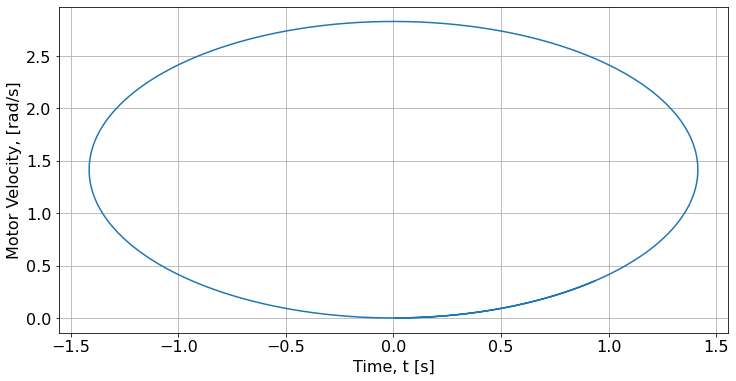

In [77]:
# initial conditions
x_0 = array([ [0],
              [0],
              [0] ])
# Solve the open loop system over a 0.1 second time window with 1 ms steps
t_OL, y_OL = ruku4(system_eqn_ol, x_0, [0, 14], 1e-2)

# Enlarge font size
rc('font', **{'size'   : 16})

pyplot.figure(figsize=(12,6))
pyplot.plot(y_OL[:,0], y_OL[:,1])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('X Position, []')
pyplot.grid()

## Run and Plot Output Varaibles vs. Time

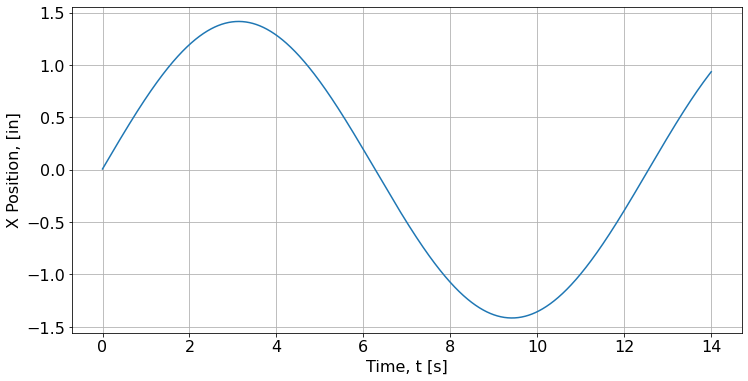

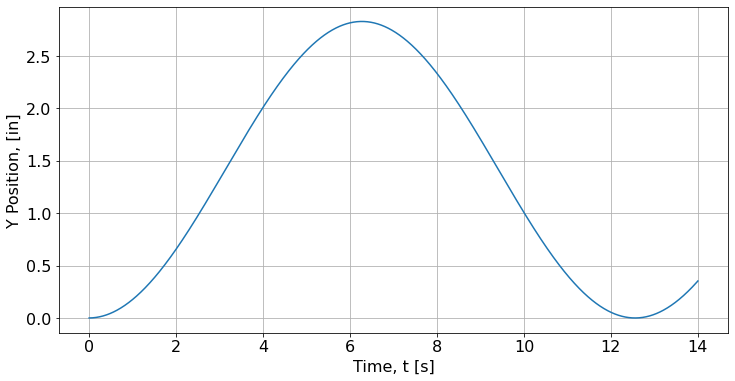

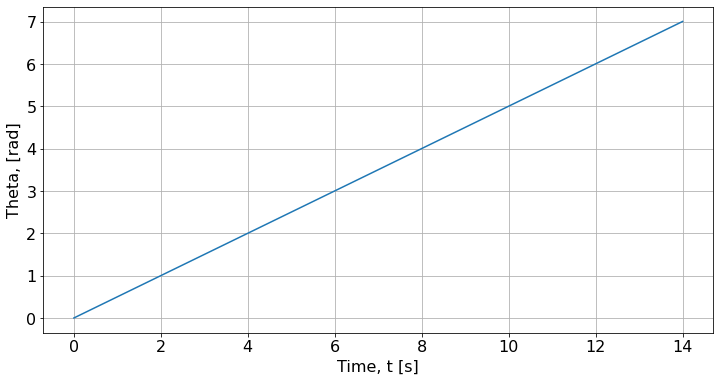

In [79]:
# plot x position vs time
pyplot.figure(figsize=(12,6))
pyplot.plot(t_OL, y_OL[:,0])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('X Position, [in]')
pyplot.grid()

# plot y position vs time
pyplot.figure(figsize=(12,6))
pyplot.plot(t_OL, y_OL[:,1])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Y Position, [in]')
pyplot.grid()

# plot theta vs time
pyplot.figure(figsize=(12,6))
pyplot.plot(t_OL, y_OL[:,2])
pyplot.xlabel('Time, t [s]')
pyplot.ylabel('Theta, [rad]')
pyplot.grid()

## Discussion Questions

*1. Explore the validity of the no-slip assumption and any other assumptions required for the kinematic model in favor of a full dynamic model. Consider things like how the motors may or may not easily integrate with the model, how the mass and friction properties of the system may influence the model, and any other effects that may not match the idealized nature of the kinematic model. Is the kinematic model good enough for our purposes?*

The kinematic model is good enough for our purposes, however there are a few considerations in the implementation in real life. For the no-slip assumption, it implies that the wheels to not slip or skid in any way, however in reality there are many factors that will contribute to violating this model such as wheel to ground interaction on the basis of material properties, and  motor speeds that could result in slips such as right motor 100% forward, and left motor of which could slip. This model also assumes instantaneous velocity values in each wheel velocity, however in reality the velocity is more of a step response and that response time could have some impact on the no-slip model or the vehicle dynamics. Without having completed my lab 5, I am not entirely sure how the robot will run, and once I have it runnin, I bet there will be more visiable issues with the model. Despite these issues, it gives enough of a valid result to illustrate the path following based on given radius and desired velocities.

*2. One of the problems with models like this is that significant deviation or drift will occur between the simulation and the behavior of the real vehicle, especially when accumulated over a long simulation. The concept of dead reckoning is that we can predict the position of a system simply by integrating its velocity or acceleration over time. Naturally, small devi- ations, like those caused by minor wheel slip, add up over time. A small error in velocity, once integrated over time to produce position, can lead to wildly inaccurate estimations of position.*

*How can we correct for this drift error? What other information would help us keep our simulated model tracking with reality? Hint: consider what kind of sensors may be added to the robot to measure the value of your selected state variables.*

The first thing that I think of when answering this problem is that minor wheel slip might cause encoder values to jump in a predicatable, but excessive manner. Maybe a way to solve this issue could be to detect these encoder slips and then adjust selected parameteres to reflect the wheel slip and try and minimize the effect it has on the long simulation. 

In line with the hint, the three state variables are X position, Y position, and $\Phi$ or Yaw position. An IMU such as the BNO055 we have used could be utilized to measure the Yaw position and compare it to the simulation results. This would let us know where the Yaw starts to deviate from the simulation and preventative measures could then be taken to find the cause of the drift error and remove it. 

Lastly, in order to ensure that we have correct robot behavior, a feedback control system could e implemented in order to confirm that desired velocities and steering angles are being accurately achieved by the robot

*3. While this is not a controls course, you will need to implement some kind of controller on your robot to complete the term project. For this question, investigate ways in which you may incorporate feedback into your system to make the robot move in ways that will be advantageous for the term project. Address nuances such as:\
• What sensor inputs will be useful for feedback.\
• How you might split up a complicated path into segments such as straight lines, circular arcs, in-place turns, etc.*

Based on the current tools I have added to my robot design, my options are Reflectance array sensors, encoder values or IMU data to determine important robot information. On the software side, I can implement a feedback control system to improve responses from the robot. The minimalist approach will allow my robot to compute faster, and might be advantageous as I will have less things to worry about, faster computations, and will be able to spend more time optimizing my usage of IMU and encoder values.

As for complicated path handling, circular arcs should be able to be done through fine tuning of the PID controller in order to quickly update the reflectance sensor values an adjust wheel velocoties to maintain the position of the line in the center of my reflectance sensor.
For in-place turns, I am not sure how I will detect that a turn needs to be made. Since my refelctance array sensor is placed at the front of my robot, all turns will be handled essentially like an arc. When the sensor gets to the end of a straight line, and the start of, for edample, a 90 degree right turn, the right half of the reflectance sensor will be detecting black, so it will turn right until it can reposition the black to the center of the array. For a proper in-place turn, I can simply make the input velocities of the two wheels be equal and opposite, which should result in an in-place spin about the center. IMU data can be used to validate the position of the robot and ensure that the center is within some tolerance of where it started.

*4. Is it possible to determine the orientation and location of the robot after it has followed a specific path simply by knowing the angle swept out by each wheel? If not, would it be possible to know the orientation and location with a time-history of the angle swept out by each wheel? If you know the robot’s orientation and location, can you figure out the angle swept out by each wheel?
Investigate what information is required to track the robots absolute position in space, or possible its position relative to particular maneuver, like a circular arc. What kind of data will you need to track in your firmware to make use of this information?*

Based off of only knowing the sweep angles of each wheel, orientation and location can be determined, but there are challenges associate with it as a given set of wheel angles could correspond to multiple possible poses for the robot. With no reference point, orientation is basically ambiguous and would be difficult to determine correctly without more information.
If we knew the time history of the robot corresponding to each wheel angle, it would be better than just the wheel angles, but it would still run into the same issues due to redundency. A robot can get to the same final position and orientation by following various paths, so there isn't a direct 1-1 mapping from time history to a final pose, other information is still required to get a full picture.
In order to get the best idea of an aboslute position for the robot, I think that collecting wheel encoder data, and IMU data on acceleration and angular velocities would be essential in determining the absolute orientation. If we treat each movement of the robot like it is moving along an arc, we can track individual movements at each time step from one position to the next. Utilizing encoder data from the left and right wheels along with IMU data, the amount of distance that the robot traveled in the x and y direction should be able to be calculated for each time step. Since each of these distances is going to be local to a different coordinate system, some matrix transformations will need to be done in order to bring it back to the global system, but once that is done, I believe that we would be able to track the path of the robot over time.





